# Experiments

In this notebook, I will run some experiments to see how the model performs on different settings.

First, I will train the dataset on a small one layer CNN, medium one layer CNN and three layer CNN.

Another experiment will be to see how the model performs with the laplacian of the images. This operation highlights the edges of the images, which could improve the accuracy of the model.

Finally, I will also try to use the largest rectangle inside the object.

# Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

LABELS = {0: "Upper part", 1: "Bottom part", 2: "One piece", 3: "Footwear", 4: "Bags"}

# Load data and functions

In [2]:
def load_data():
    """
    Load data from pickle file
    """
    with open('../data/processed/fashion_mnist_k5.pkl', 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = load_data()

In [3]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score


def load_data(path='../data/processed/fashion_mnist_k5.pkl'):
    """
    Load data from pickle file
    """
    with open(path, 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y
        

def cast_and_normalize_images(train, test):
    """
    Convert from integers to floats and normalize to range 0-1
    """
    # Apply sobel filter
    from scipy import ndimage
    for i in range(train.shape[0]):
        img = train[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        train[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255
        

    for i in range(test.shape[0]):
        img = test[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        test[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255

    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    return train_norm, test_norm


def get_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    # model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/16
3000/3000 [==============================] - 33s 10ms/step - loss: 0.1981 - accuracy: 0.9298 - val_loss: 0.1299 - val_accuracy: 0.9542 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 30s 10ms/step - loss: 0.1049 - accuracy: 0.9595 - val_loss: 0.1148 - val_accuracy: 0.9602 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 31s 10ms/step - loss: 0.0817 - accuracy: 0.9674 - val_loss: 0.0961 - val_accuracy: 0.9674 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 30s 10ms/step - loss: 0.0635 - accuracy: 0.9739 - val_loss: 0.1051 - val_accuracy: 0.9672 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 30s 10ms/step - loss: 0.0502 - accuracy: 0.9783 - val_loss: 0.1288 - val_accuracy: 0.9586 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 30s 10ms/step - loss: 0.0391 - accuracy: 0.9820 - val_loss: 0.1225 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 7/16
3000/3000 [========================

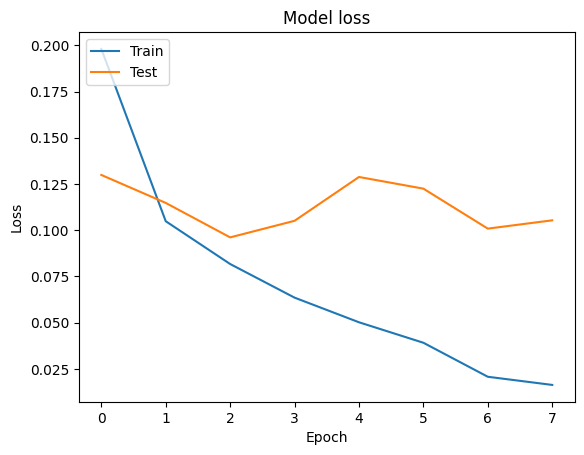

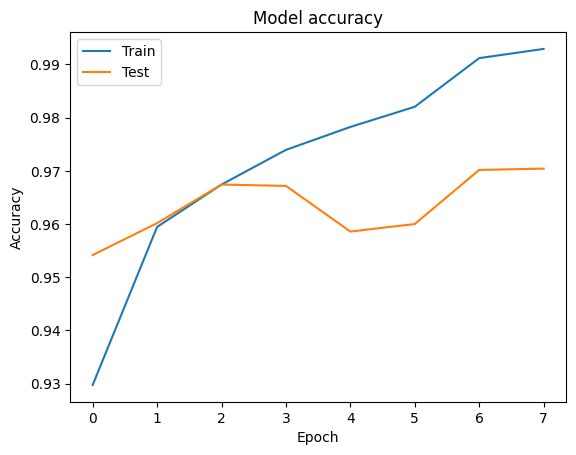

313/313 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4000
           1       0.99      0.97      0.98      1000
           2       0.88      0.90      0.89      1000
           3       1.00      1.00      1.00      3000
           4       0.97      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000

[[3867    5  103    4   21]
 [  10  969   17    0    4]
 [  88    5  903    0    4]
 [   2    0    0 2995    3]
 [  20    0    3    8  969]]


In [4]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
model = get_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
          class_weight={0: 0.5, 1: 2, 2: 2, 3: 0.667, 4: 2},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
model_loss = model.history.history['loss']
model_val_loss = model.history.history['val_loss']
plt.plot(model_loss)
plt.plot(model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/model_loss.png')
plt.show()

model_acc = model.history.history['accuracy']
model_val_acc = model.history.history['val_accuracy']
plt.plot(model_acc)
plt.plot(model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/model_acc.png')
plt.show()

# Evaluate model
y_pred = model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


At the end, the results are slightly worse than the original images.

# Bigger model

In [5]:
def get_bigger_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/16
3000/3000 [==============================] - 41s 13ms/step - loss: 0.2999 - accuracy: 0.8921 - val_loss: 0.2647 - val_accuracy: 0.9038 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 39s 13ms/step - loss: 0.1684 - accuracy: 0.9387 - val_loss: 0.1725 - val_accuracy: 0.9426 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 39s 13ms/step - loss: 0.1391 - accuracy: 0.9495 - val_loss: 0.1764 - val_accuracy: 0.9384 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 39s 13ms/step - loss: 0.1239 - accuracy: 0.9550 - val_loss: 0.1690 - val_accuracy: 0.9439 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 39s 13ms/step - loss: 0.1135 - accuracy: 0.9570 - val_loss: 0.1274 - val_accuracy: 0.9567 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 39s 13ms/step - loss: 0.1045 - accuracy: 0.9574 - val_loss: 0.1365 - val_accuracy: 0.9513 - lr: 0.0100
Epoch 7/16
3000/3000 [========================

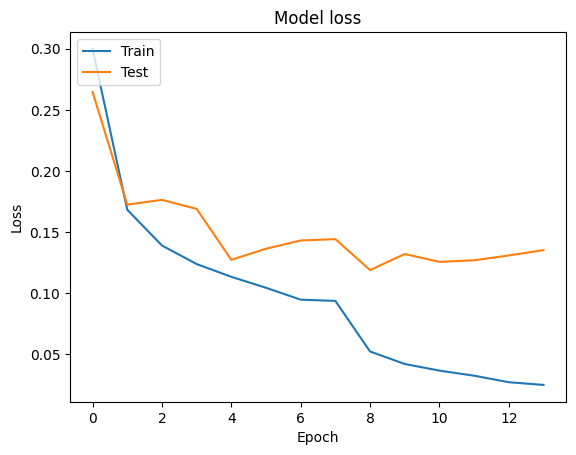

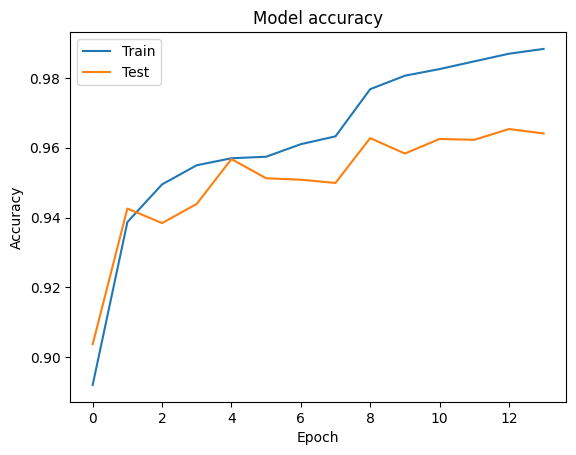

313/313 [==============================] - 3s 7ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4000
           1       0.98      0.96      0.97      1000
           2       0.84      0.89      0.86      1000
           3       0.99      1.00      1.00      3000
           4       0.97      0.96      0.96      1000

    accuracy                           0.96     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000

[[3826    8  141    2   23]
 [  13  965   19    1    2]
 [ 102    8  887    2    1]
 [   1    0    3 2993    3]
 [  27    2    1   12  958]]


In [6]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
big_model = get_bigger_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

big_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
          class_weight={0: 0.5, 1: 2, 2: 2, 3: 0.667, 4: 2},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
big_model_loss = big_model.history.history['loss']
big_model_val_loss = big_model.history.history['val_loss']
plt.plot(big_model_loss)
plt.plot(big_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_loss.png')
plt.show()

big_model_acc = big_model.history.history['accuracy']
big_model_val_acc = big_model.history.history['val_accuracy']
plt.plot(big_model_acc)
plt.plot(big_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_acc.png')
plt.show()

# Evaluate model
y_pred = big_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


# Small model

In [7]:
def get_small_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
small_model = get_small_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

small_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
          class_weight={0: 0.5, 1: 2, 2: 2, 3: 0.667, 4: 2},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

Epoch 1/16
3000/3000 [==============================] - 23s 7ms/step - loss: 0.2225 - accuracy: 0.9261 - val_loss: 0.1927 - val_accuracy: 0.9342 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 21s 7ms/step - loss: 0.1300 - accuracy: 0.9519 - val_loss: 0.1195 - val_accuracy: 0.9593 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 21s 7ms/step - loss: 0.1039 - accuracy: 0.9597 - val_loss: 0.1387 - val_accuracy: 0.9539 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 24s 8ms/step - loss: 0.0887 - accuracy: 0.9650 - val_loss: 0.1320 - val_accuracy: 0.9556 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 23s 8ms/step - loss: 0.0743 - accuracy: 0.9681 - val_loss: 0.1173 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 23s 8ms/step - loss: 0.0646 - accuracy: 0.9724 - val_loss: 0.1227 - val_accuracy: 0.9568 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================

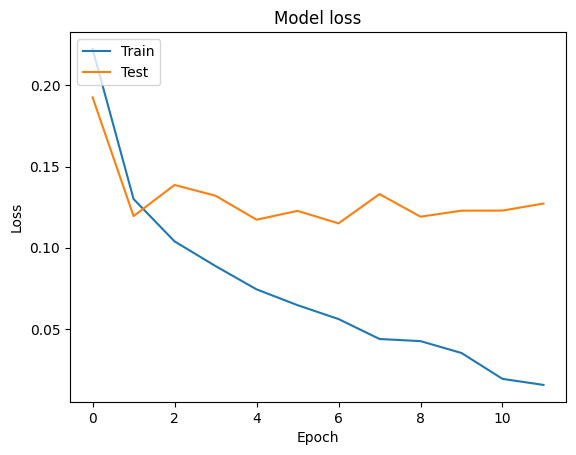

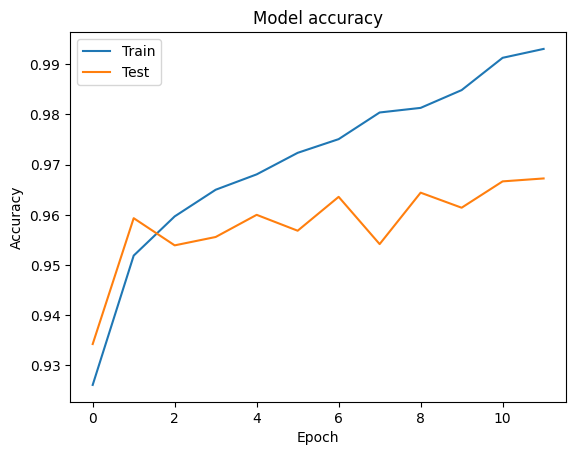

In [9]:
# Plot loss and accuracy
small_model_loss = small_model.history.history['loss']
small_model_val_loss = small_model.history.history['val_loss']
plt.plot(small_model_loss)
plt.plot(small_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/small_model_loss.png')
plt.show()

small_model_acc = small_model.history.history['accuracy']
small_model_val_acc = small_model.history.history['val_accuracy']
plt.plot(small_model_acc)
plt.plot(small_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/small_model_acc.png')
plt.show()

In [10]:

# Evaluate model
y_pred = small_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


313/313 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4000
           1       0.99      0.97      0.98      1000
           2       0.86      0.91      0.88      1000
           3       1.00      1.00      1.00      3000
           4       0.97      0.96      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000

[[3851    4  124    4   17]
 [   9  966   23    0    2]
 [  86    3  906    0    5]
 [   1    0    0 2998    1]
 [  26    1    2    7  964]]


# 3 plots

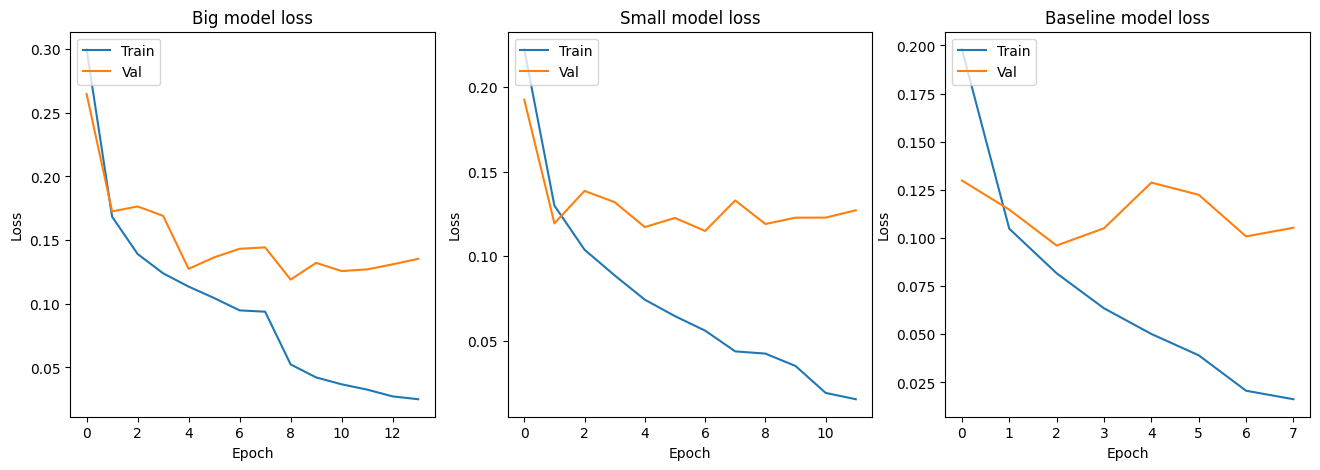

313/313 [==============================] - 2s 5ms/step


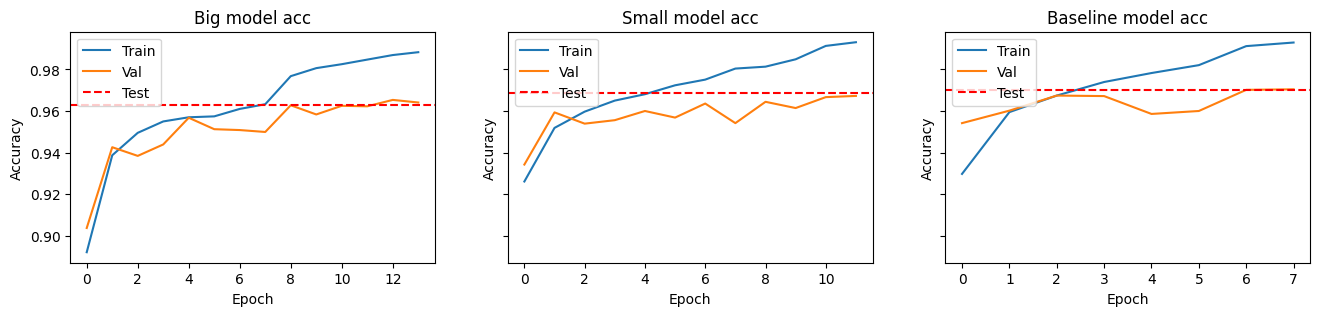

In [11]:
# Plot loss 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].plot(big_model_loss)
axs[0].plot(big_model_val_loss)
axs[0].set_title('Big model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[1].plot(small_model_loss)
axs[1].plot(small_model_val_loss)
axs[1].set_title('Small model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
axs[2].plot(model_loss)
axs[2].plot(model_val_loss)
axs[2].set_title('Baseline model loss')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Val'], loc='upper left')

plt.savefig('../plots/loss_3_cnn.png')
plt.show()

# Plot acc 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 3), sharey=True)

axs[0].plot(big_model_acc)
axs[0].plot(big_model_val_acc)
axs[0].set_title('Big model acc')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
y_pred = big_model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[0].axhline(y=test_acc, color='r', linestyle='--')
axs[0].legend(['Train', 'Val', 'Test'], loc='upper left')

axs[1].plot(small_model_acc)
axs[1].plot(small_model_val_acc)
axs[1].set_title('Small model acc')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
y_pred = small_model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[1].axhline(y=test_acc, color='r', linestyle='--')
axs[1].legend(['Train', 'Val', 'Test'], loc='upper left')

axs[2].plot(model_acc)
axs[2].plot(model_val_acc)
axs[2].set_title('Baseline model acc')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
y_pred = model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[2].axhline(y=test_acc, color='r', linestyle='--')
axs[2].legend(['Train', 'Val', 'Test'], loc='upper left')


plt.savefig('../plots/accuracy_3_cnn.png')
plt.show()

# Train with Laplacian of the image

The laplacian of an image is the second derivative of it and it highlights the edges of the image.

I have an intuition that it could help on the classification, so I will try to train the model with it.

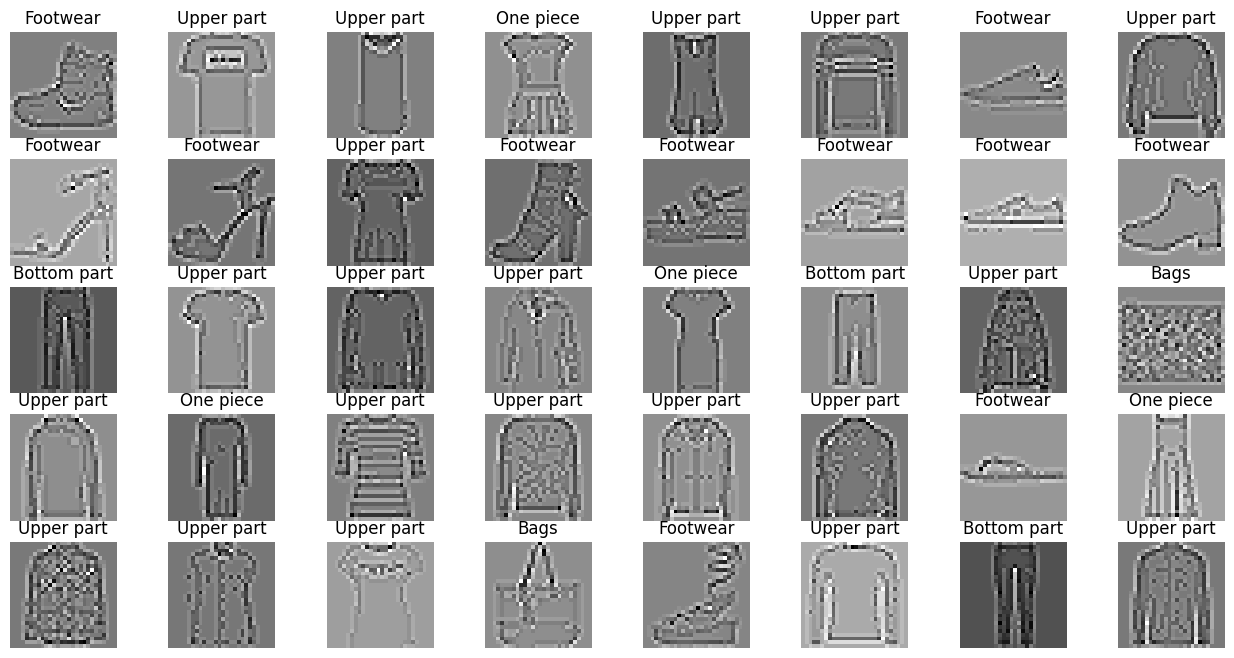

In [12]:
train_x, train_y, test_x, test_y = load_data()

f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[:40]):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    laplacian = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255
    ax[i//8, i%8].imshow(laplacian, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])

plt.show()

In [13]:
# Calculate laplacian
for i, image in enumerate(train_x):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    train_x[i] = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255

for i, image in enumerate(test_x):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    test_x[i] = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255

Epoch 1/16
3000/3000 [==============================] - 32s 10ms/step - loss: 0.2138 - accuracy: 0.9269 - val_loss: 0.1875 - val_accuracy: 0.9357 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 30s 10ms/step - loss: 0.1098 - accuracy: 0.9571 - val_loss: 0.1410 - val_accuracy: 0.9525 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 31s 10ms/step - loss: 0.0831 - accuracy: 0.9659 - val_loss: 0.1247 - val_accuracy: 0.9567 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 32s 11ms/step - loss: 0.0645 - accuracy: 0.9717 - val_loss: 0.1901 - val_accuracy: 0.9360 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 32s 11ms/step - loss: 0.0523 - accuracy: 0.9769 - val_loss: 0.0974 - val_accuracy: 0.9682 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 32s 11ms/step - loss: 0.0423 - accuracy: 0.9809 - val_loss: 0.1188 - val_accuracy: 0.9622 - lr: 0.0100
Epoch 7/16
3000/3000 [========================

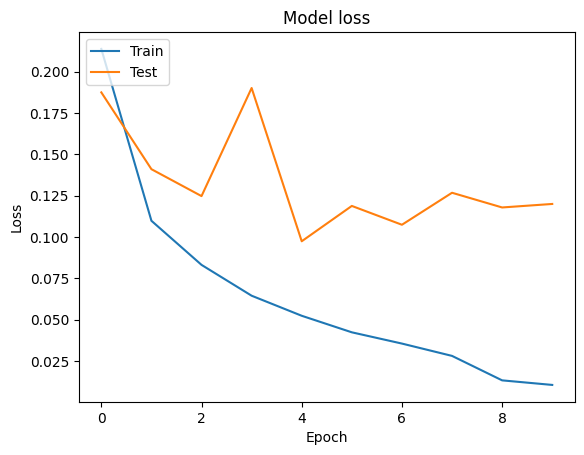

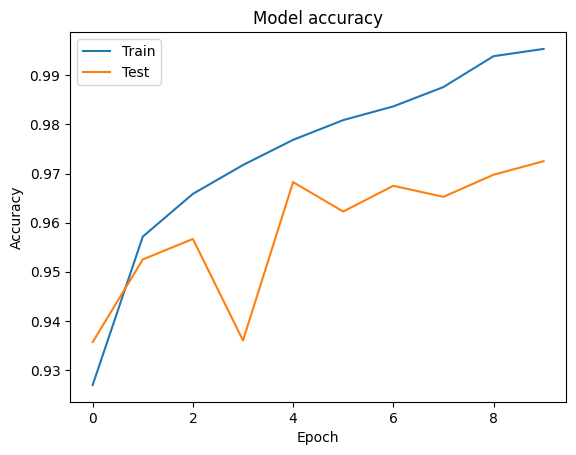

313/313 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4000
           1       0.99      0.97      0.98      1000
           2       0.90      0.88      0.89      1000
           3       1.00      1.00      1.00      3000
           4       0.98      0.96      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000

[[3906    7   72    3   12]
 [  11  970   18    0    1]
 [ 111    5  879    1    4]
 [   4    0    0 2992    4]
 [  19    0    9   10  962]]


In [14]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
big_model = get_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

big_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
          class_weight={0: 0.5, 1: 2, 2: 2, 3: 0.667, 4: 2},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
big_model_loss = big_model.history.history['loss']
big_model_val_loss = big_model.history.history['val_loss']
plt.plot(big_model_loss)
plt.plot(big_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_loss.png')
plt.show()

big_model_acc = big_model.history.history['accuracy']
big_model_val_acc = big_model.history.history['val_accuracy']
plt.plot(big_model_acc)
plt.plot(big_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_acc.png')
plt.show()

# Evaluate model
y_pred = big_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


The results are very similar as the original images.

# Largest interior rectangle

I will try to use the largest interior rectangle of the image as input to the model. 

In order to get the largest interior rectangle, I have to binarize the image.

Then, I will train a Decision Tree and a Random Forest with these features.

In [15]:
# !pip install largestinteriorrectangle

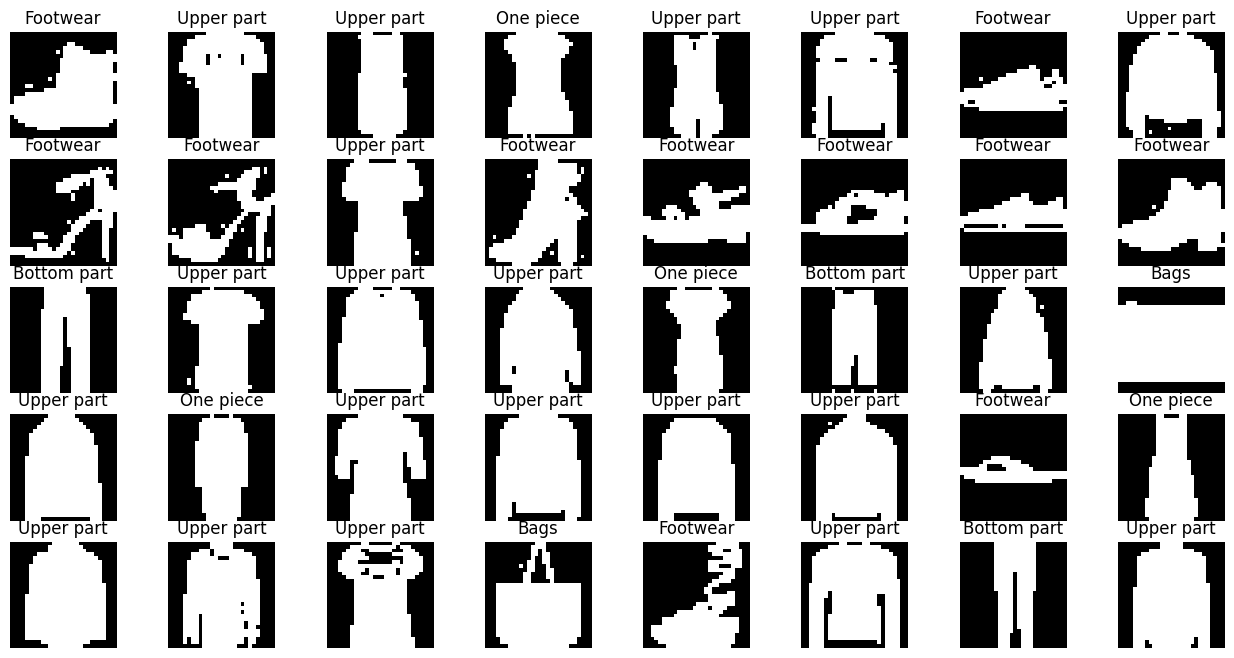

In [16]:
train_x, train_y, test_x, test_y = load_data()

f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[:40]):
    image = (image > 5) * 255
    ax[i//8, i%8].imshow(image, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])

plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


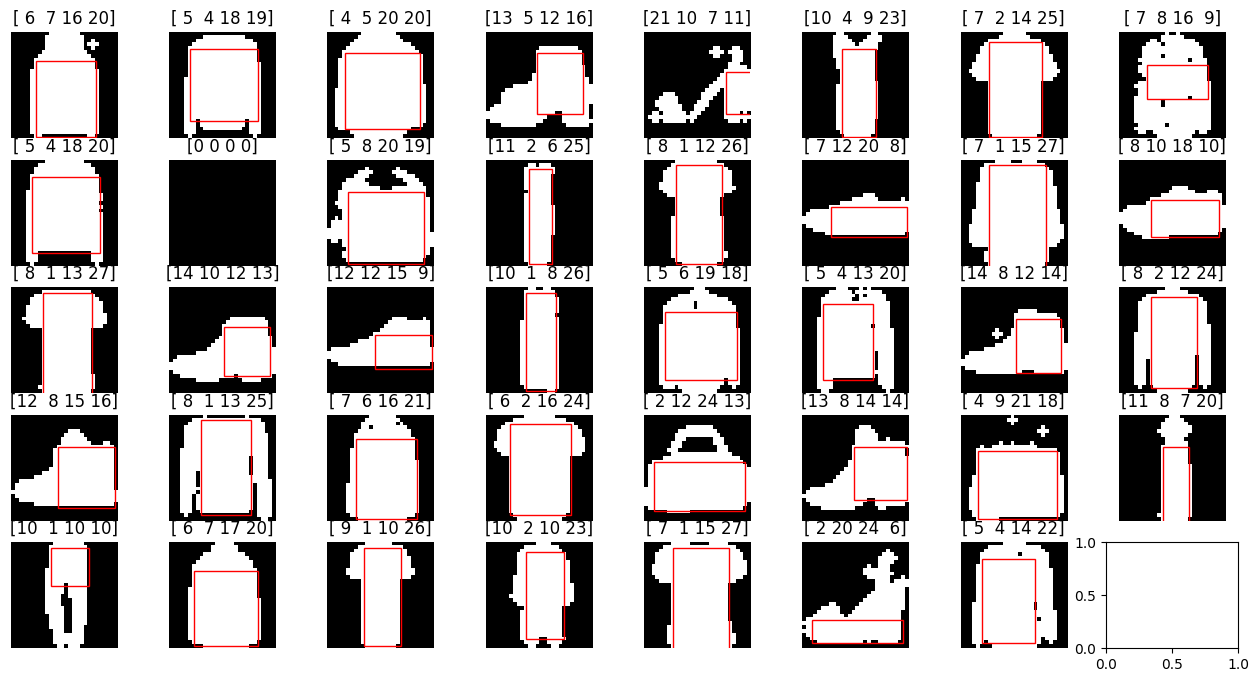

In [17]:
import largestinteriorrectangle as lir
from matplotlib import patches

train_x, train_y, test_x, test_y = load_data()

f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[39000:39039]):
    image = image.reshape((28, 28))
    image = (image > 0) * 1
    # Opening operation
    image = ndimage.binary_opening(image, iterations=1)

    rect_points = lir.lir(image)
    ax[i//8, i%8].imshow(image, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(rect_points)
    # ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])
    # Draw rectangle
    rect = patches.Rectangle((rect_points[0], rect_points[1]), rect_points[2], rect_points[3], linewidth=1, edgecolor='r', facecolor='none')
    ax[i//8, i%8].add_patch(rect)

plt.show()

In [18]:
import pandas as pd
from tqdm import tqdm

def apply_lir_to_dataset(dataset):
    data = []
    for i, image in tqdm(enumerate(dataset)):
        image = image.reshape((28, 28))
        image = (image > 0) * 1
        # Opening operation
        image = ndimage.binary_opening(image, iterations=1)
        rect_points = lir.lir(image)
        data.append(rect_points)

    return data

train_x, train_y, test_x, test_y = load_data()

train_data = apply_lir_to_dataset(train_x)
test_data = apply_lir_to_dataset(test_x)

60000it [13:04, 76.50it/s] 
10000it [02:14, 74.38it/s]


In [19]:
# Enter data in df
df_train = pd.DataFrame(train_data, columns=['x1', 'y1', 'width', 'height'])
df_train['proportion'] = df_train['width'] / df_train['height']
df_train = df_train.fillna(0)

df_test = pd.DataFrame(test_data, columns=['x1', 'y1', 'width', 'height'])
df_test['proportion'] = df_test['width'] / df_test['height']
df_test = df_test.fillna(0)


In [20]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight={0: 0.5, 1: 2, 2: 2, 3: 0.667, 4: 2})
tree.fit(df_train, np.argmax(train_y, axis=1))

# Evaluate decision tree
y_pred = tree.predict(df_test)
print(classification_report(np.argmax(test_y, axis=1), y_pred))
print(confusion_matrix(np.argmax(test_y, axis=1), y_pred, normalize='true'))

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_jobs=-1, class_weight={0: 0.5, 1: 2, 2: 2, 3: 0.667, 4: 2})
forest.fit(df_train, np.argmax(train_y, axis=1))

# Evaluate random forest
y_pred = forest.predict(df_test)
print(classification_report(np.argmax(test_y, axis=1), y_pred))
print(confusion_matrix(np.argmax(test_y, axis=1), y_pred, normalize='true'))


              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4000
           1       0.89      0.89      0.89      1000
           2       0.67      0.78      0.72      1000
           3       0.97      0.96      0.97      3000
           4       0.73      0.83      0.78      1000

    accuracy                           0.87     10000
   macro avg       0.83      0.86      0.84     10000
weighted avg       0.88      0.87      0.88     10000

[[0.836      0.01375    0.07775    0.01075    0.06175   ]
 [0.047      0.892      0.054      0.004      0.003     ]
 [0.154      0.041      0.78       0.011      0.014     ]
 [0.01266667 0.00233333 0.00533333 0.96266667 0.017     ]
 [0.118      0.006      0.009      0.033      0.834     ]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      4000
           1       0.91      0.89      0.90      1000
           2       0.69      0.78      0.73      1000
   

# Time to predict

In [25]:
%timeit tree.predict(df_test)
%timeit forest.predict(df_test)
%timeit model.predict(test_x, verbose=0)

9.5 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
142 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.02 s ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
sample_df = df_train.iloc[0].to_frame().T
sample = test_x[0].reshape(1, 28, 28, 1)

%timeit tree.predict(sample_df)
%timeit forest.predict(sample_df)
%timeit model.predict(sample, verbose=0)

2.71 ms ± 80.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.4 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
160 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Conclusions

I have achieved a 98% accuracy on the test set of this reduced version of Fashion MNIST.

I have tried three different cnn models with different number of layers: One small layer, one bigger layer and three layers.

The best results were achieved with the one bigger layer, with 98% accuracy.

I also tried two experiments: Using the laplacian of the image and using the largest interior rectangle of the image.

- The laplacian of the image is the second derivative of it and it helps highlighting the edges of the image. 

- The largest interior rectangle is the largest rectangle that can be drawn inside the object.

The results for the laplacian were slightly worse than the original images and for the largest interior rectangle were just a 88% accuracy. On the other hand, the prediction time was 50x faster for an individual sample and more than 200x faster for the whole test set.
